<a href="https://colab.research.google.com/github/Ichin-0419/hp/blob/main/competition_2_ipynb_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import numpy as np  # 数値計算や配列操作を行うためのライブラリ
import pandas as pd  # 表形式のデータを扱うためのライブラリ
import matplotlib.pyplot as plt  # データ可視化のための基本的なグラフ描画ライブラリ
import seaborn as sns  # 高機能な統計グラフを描画するライブラリ
from sklearn.preprocessing import LabelEncoder  # カテゴリ変数を数値に変換するエンコーダ
from sklearn.ensemble import RandomForestClassifier  # ランダムフォレストによる分類器
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # 線形判別分析
from sklearn.model_selection import StratifiedKFold  # 層化K分割交差検証を行うクラス
from sklearn.metrics import roc_auc_score  # ROC AUCスコアを計算する評価指標
from sklearn.preprocessing import PolynomialFeatures

In [8]:
train = pd.read_csv("/content/drive/MyDrive/NFL_Draft_Prediction_train.csv")  # 学習用データの読み込み
test = pd.read_csv("/content/drive/MyDrive/NFL_Draft_Prediction_test.csv")
# 使わない列の削除
train = train.drop(columns=["Id", "School"])
test = test.drop(columns=["Id","School"])

for df in [train, test]:
  df['Age_isnull'] = df['Age'].isnull().astype(int)

for df in [train, test]:
  df['Sprint_isnull'] = df['Sprint_40yd'].isnull().astype(int)

# 平均で補完する対象の列
cols_to_fill = ['Age', 'Sprint_40yd', 'Vertical_Jump', 'Bench_Press_Reps',
                'Broad_Jump', 'Agility_3cone', 'Shuttle']

# train の平均で train/test 両方を補完
for col in cols_to_fill:
    mean_value = train[col].mean()
    train[col] = train[col].fillna(mean_value)
    test[col] = test[col].fillna(mean_value)

    # カテゴリデータをラベルエンコーディング
label_encoders = {}
for c in ["Player_Type", "Position_Type", "Position"]:
    label_encoders[c] = LabelEncoder()
    train[c] = label_encoders[c].fit_transform(train[c].astype(str))
    test[c] = label_encoders[c].transform(test[c].astype(str))

#特徴量エンジニアリング
for df in [train, test]:
  df['BMI'] = df['Weight'] / (df['Height'] ** 2)

# Broad_Jumpの標準化
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
train['Broad_Jump'] = ss.fit_transform(train[['Broad_Jump']])
test['Broad_Jump'] = ss.transform(test[['Broad_Jump']])

# 交差項の作成
pf = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)

# 訓練データからターゲット変数を除いた特徴量部分
features_for_poly_train = train.drop(columns=["Drafted"])

# PolynomialFeaturesをフィットさせ、訓練データを変換
X_transformed = pf.fit_transform(features_for_poly_train)
# 新しい特徴量を持つDataFrameを作成
train_transformed_df = pd.DataFrame(X_transformed, columns=pf.get_feature_names_out(features_for_poly_train.columns), index=train.index)

# ターゲット変数を再結合して、新しいtrain DataFrameとする
train = pd.concat([train_transformed_df, train[['Drafted']]], axis=1)

# テストデータに同じ変換を適用
# テストデータにはターゲット変数がないため、そのまま変換
test_transformed = pf.transform(test)
# 新しい特徴量を持つDataFrameを作成し、新しいtest DataFrameとする
test = pd.DataFrame(test_transformed, columns=pf.get_feature_names_out(test.columns), index=test.index)

# 特徴量と目的変数に分ける
X = train.drop(columns=["Drafted"])
y = train["Drafted"]

# モデルとCVの設定
model = LinearDiscriminantAnalysis()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# スコア・予測格納用
auc_scores = []
test_pred_proba_list = []

# Stratified K-Fold による学習と評価
for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}")

    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # モデル学習
    model.fit(X_train, y_train)

    # バリデーション予測 & スコア
    y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid, y_valid_pred_proba)
    auc_scores.append(auc)
    print(f"  AUC: {round(auc, 4)}")

    # テストデータ予測を保存
    test_pred_proba = model.predict_proba(test)[:, 1]
    test_pred_proba_list.append(test_pred_proba)

# 平均AUCを表示
mean_auc = np.mean(auc_scores)
print("\nAverage Validation AUC:", round(mean_auc, 4))

# テスト予測の平均を計算
test_pred_proba_mean = np.mean(test_pred_proba_list, axis=0)

Fold 1
  AUC: 0.8049
Fold 2
  AUC: 0.8459
Fold 3
  AUC: 0.8602
Fold 4
  AUC: 0.8044
Fold 5
  AUC: 0.8331

Average Validation AUC: 0.8297


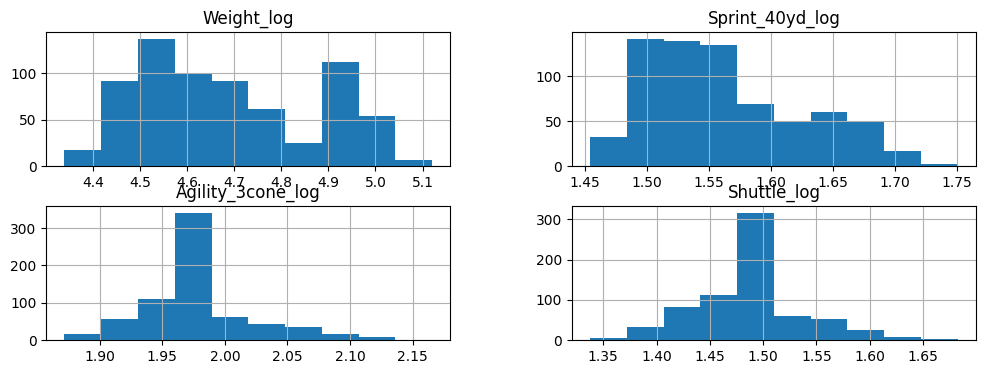

In [4]:
cols = ['Weight', 'Sprint_40yd', "Agility_3cone", "Shuttle"]
for df in [train, test]:
  X = df[cols]
  X_log = np.log(X)
  cols_log = [s + '_log' for s in cols]
  X_log.columns = cols_log
X_log.hist(figsize=(12, 4))
plt.show()

In [5]:
train.head()

,Year,Age,Height,Weight,Sprint_40yd,Vertical_Jump,Bench_Press_Reps,Broad_Jump,Agility_3cone,Shuttle,...,Player_Type Position,Player_Type Age_isnull,Player_Type BMI,Position_Type Position,Position_Type Age_isnull,Position_Type BMI,Position Age_isnull,Position BMI,Age_isnull BMI,Drafted
0,2011.0,21.0,1.9050,140.160042,5.39,59.69,29.000000,-1.904901,7.910000,4.940000,...,10.0,0.0,38.621956,50.0,0.0,193.109778,0.0,386.219556,0.0,1.0
1,2011.0,24.0,1.8288,87.089735,4.31,101.60,16.000000,1.915647,7.230447,4.399422,...,19.0,0.0,26.039614,0.0,0.0,0.000000,0.0,494.752667,0.0,1.0
2,2018.0,21.0,1.8542,92.986436,4.51,91.44,10.000000,0.841118,6.950000,4.370000,...,19.0,0.0,27.046212,0.0,0.0,0.000000,0.0,513.878028,0.0,1.0
3,2010.0,21.0,1.9304,148.778297,5.09,76.20,39.000000,-1.785509,8.120000,4.710000,...,0.0,0.0,0.000000,8.0,0.0,79.850008,0.0,159.700015,0.0,1.0
4,2016.0,21.0,1.8796,92.079251,4.64,78.74,20.236408,-0.472196,7.130000,4.200000,...,19.0,0.0,26.063390,0.0,0.0,0.000000,0.0,495.204414,0.0,1.0


12/4 0.819→0.8251→0.8297
コンペ 0.81329→

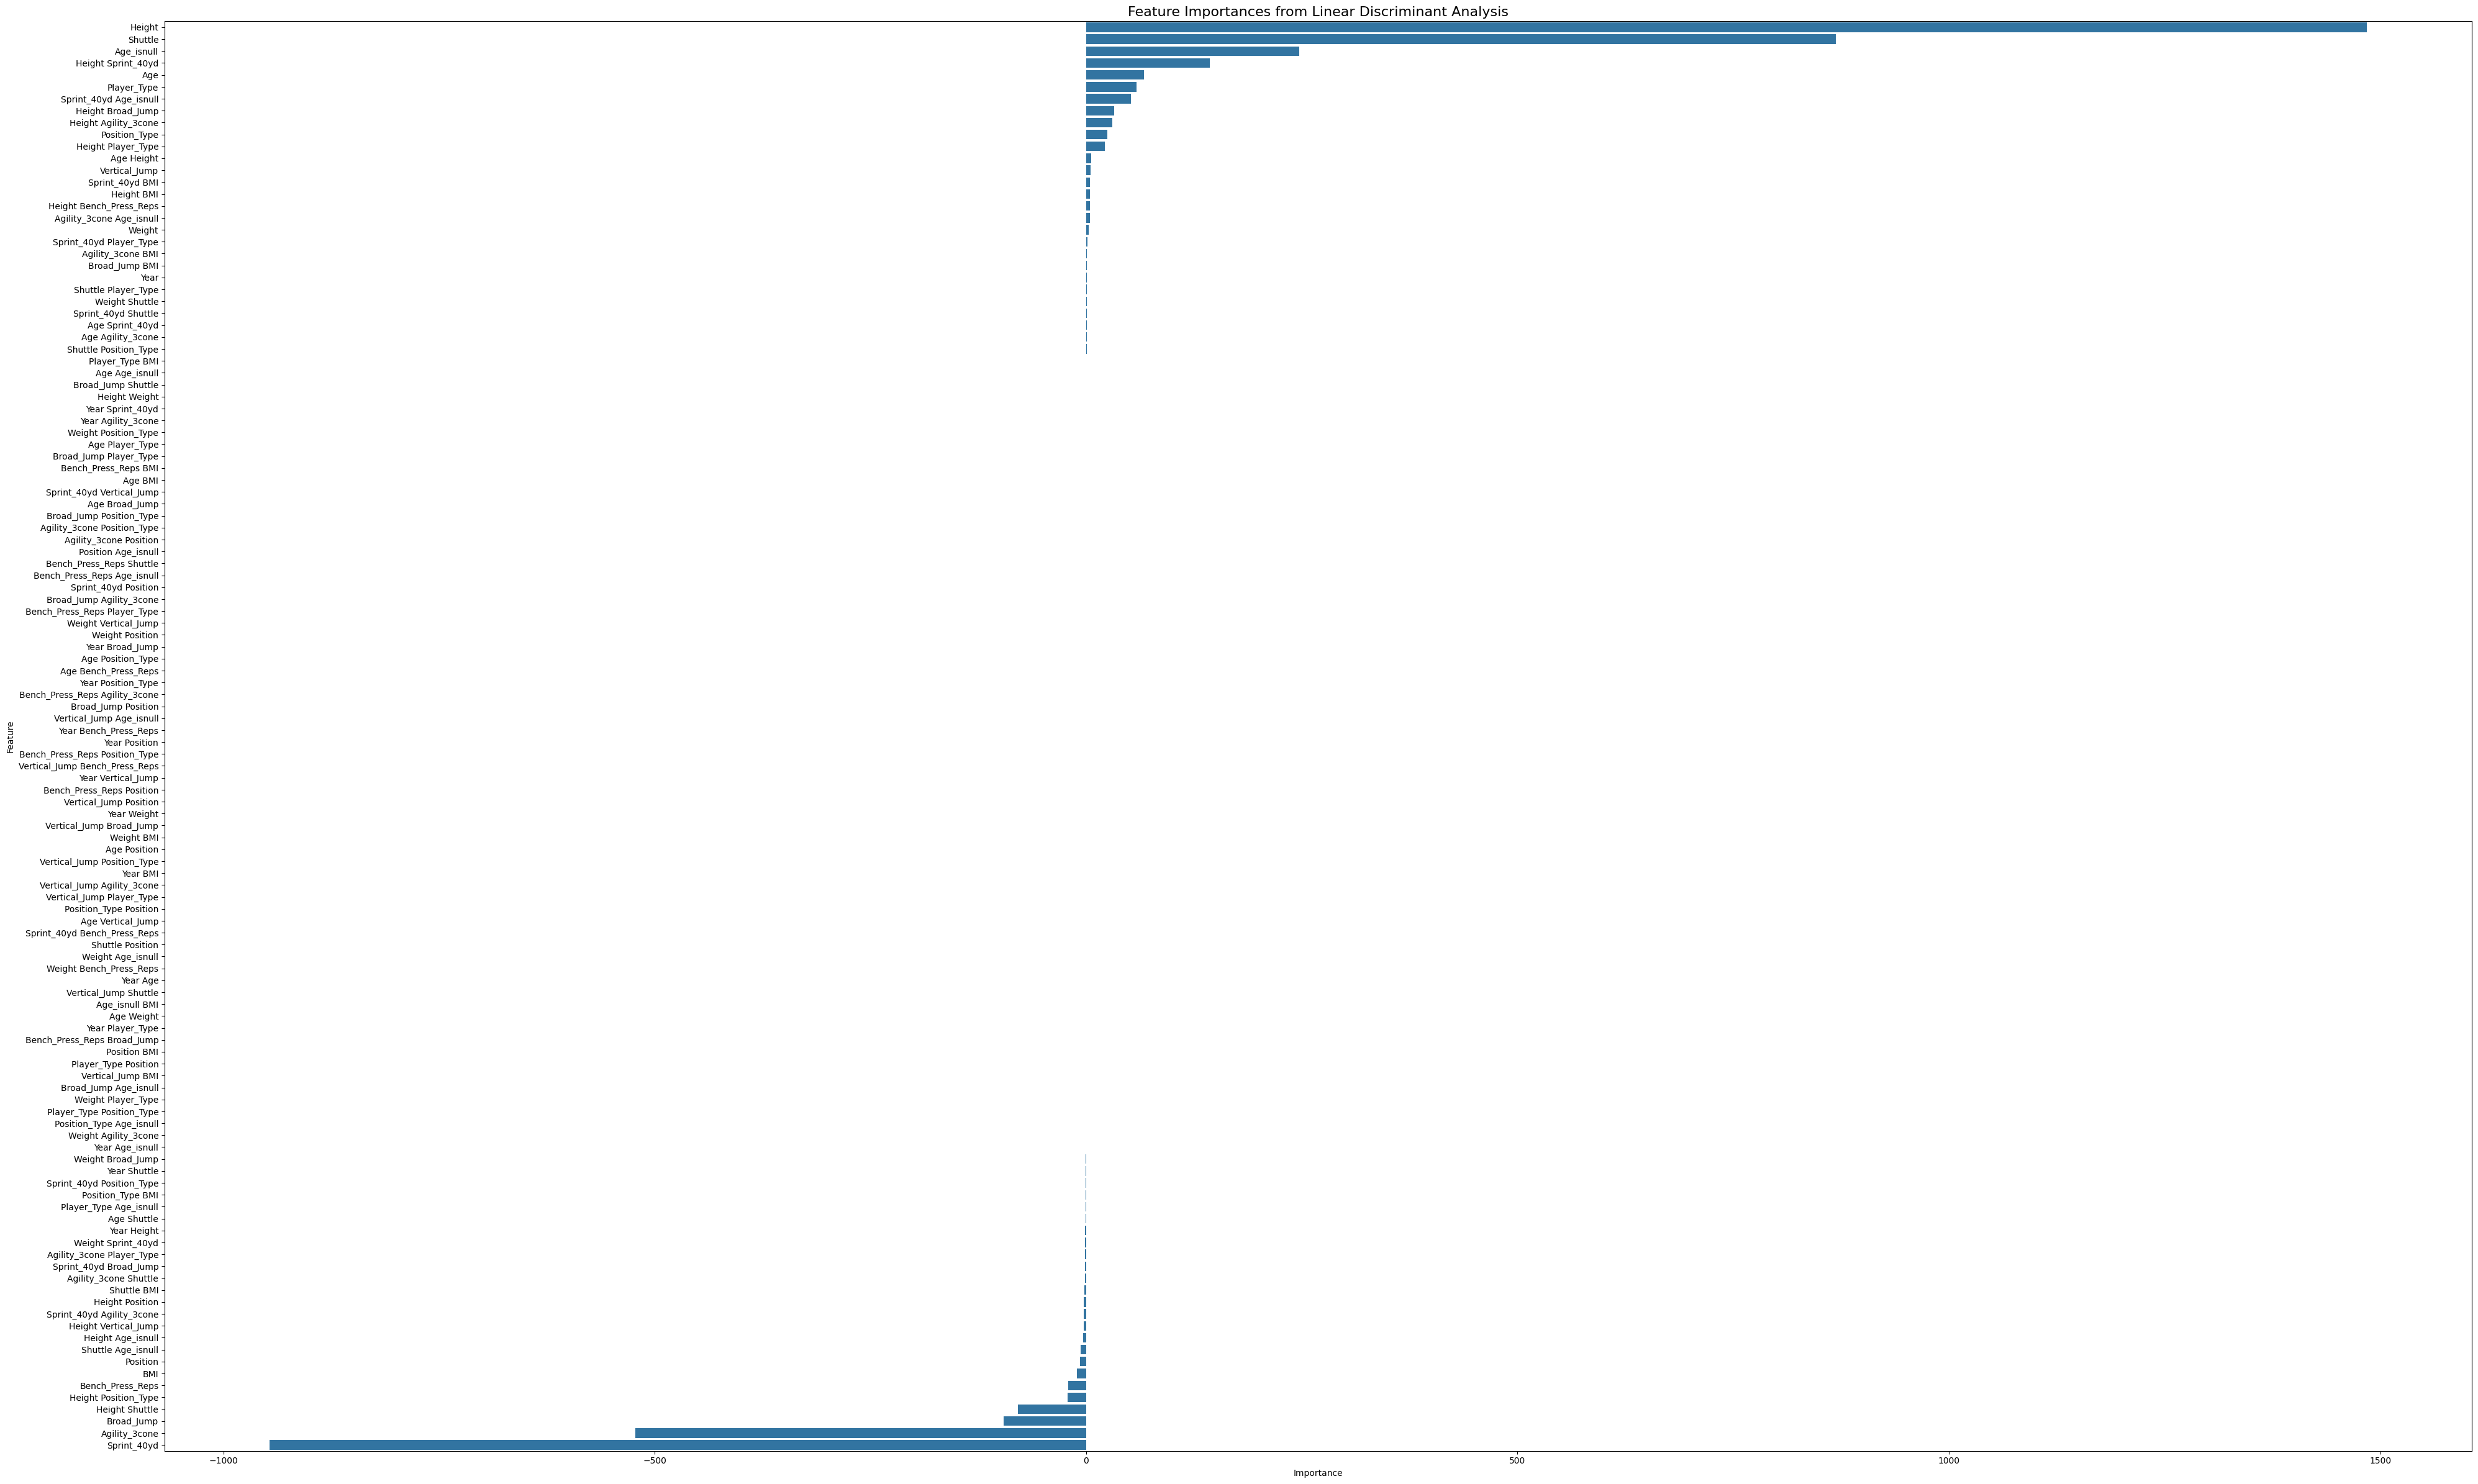

In [6]:
# 特徴量とその重要度をDataFrameにまとめる
feature_importances = pd.DataFrame({
    'Feature': train_transformed_df.columns,
    'Importance': model.coef_[0]
}).sort_values(by='Importance', ascending=False)

# 可視化
plt.figure(figsize=(40, 24))
sns.barplot(data=feature_importances, x='Importance', y='Feature')
plt.title('Feature Importances from Linear Discriminant Analysis', fontsize=16)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [7]:
# このセルを実行すると提出用のCSVファイルが作成されます
"""submission = pd.read_csv("/content/drive/MyDrive/NFL_Draft_Prediction_sample_submission.csv") # PATHは必要に応じて変更の必要があります
submission["Drafted"] = test_pred_proba_mean
submission.to_csv("/content/drive/MyDrive/NFL_Draft_Prediction_baseline_submission.csv", index=False)"""